In [87]:
import pandas as pd
import numpy as np

import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
import matplotlib.ticker as mticker
import matplotlib.dates as mdates
import calendar
import matplotlib.patches as mpatches

In [2]:
path = "../data/cleaned_data.csv"
df = pd.read_csv(path)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 4 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   DatePeriod         100000 non-null  object 
 1   AccountID          100000 non-null  int64  
 2   TransactionAmount  100000 non-null  float64
 3   Status             100000 non-null  object 
dtypes: float64(1), int64(1), object(2)
memory usage: 3.1+ MB


In [4]:
df['DatePeriod'] = pd.to_datetime(df['DatePeriod'])
df.set_index('DatePeriod', inplace=True)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 100000 entries, 2023-11-07 10:58:00 to 2023-04-30 04:59:00
Data columns (total 3 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   AccountID          100000 non-null  int64  
 1   TransactionAmount  100000 non-null  float64
 2   Status             100000 non-null  object 
dtypes: float64(1), int64(1), object(1)
memory usage: 3.1+ MB


In [6]:
df

,AccountID,TransactionAmount,Status
DatePeriod,,,
2023-11-07 10:58:00,405126,500000.0,sent
2023-11-07 10:56:00,378829,7400.0,sent
2023-11-07 10:56:00,405469,3000.0,sent
2023-11-07 10:56:00,2262,2000.0,sent
2023-11-07 10:54:00,402063,1300.0,sent
...,...,...,...
2023-04-30 05:42:00,364922,583.0,sent
2023-04-30 05:33:00,364922,3525.0,sent
2023-04-30 05:13:00,353700,2000.0,sent


In [7]:
df.AccountID.nunique()

3123

In [8]:
df.columns

Index(['AccountID', 'TransactionAmount', 'Status'], dtype='object')

# user-based insights

### (1.) number of unique AccountID exceeded 50 transactions per month and at what months?
user's transaction counts per month, and those above 50 transactions per month

/tmp/ipykernel_52279/99795331.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=total_users_exceeding_50.index, y=total_users_exceeding_50.values, palette='viridis')


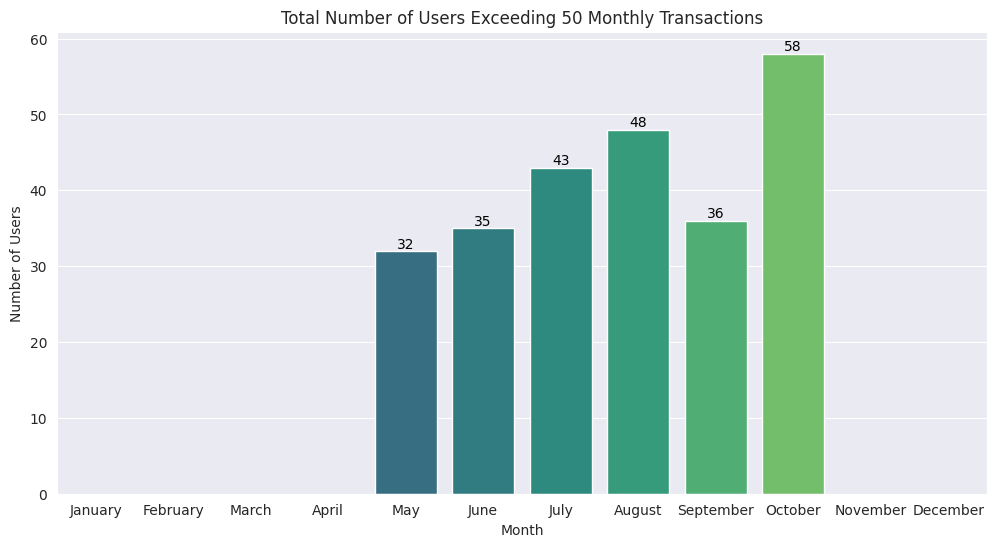

In [9]:
# Group by month and AccountID, and count transactions
monthly_count = df.groupby([df.index.month, 'AccountID'])['TransactionAmount'].count() # for each AccountID per month, count their total amount of transactionamount
exceeded_50per_month = monthly_count[monthly_count > 50] # filter accountID with transactions higher than 50

# Convert to DataFrame and rename columns
exceeded_50per_month_df = pd.DataFrame(exceeded_50per_month.reset_index(name='TransactionCount')) # store in a dataframe and reset/rename the count by the index
exceeded_50per_month_df.rename(columns={'DatePeriod': 'Month'}, inplace=True)

# Map month numbers to names
month_mapping = {
    1: 'January', 2: 'February', 3: 'March', 4: 'April', 5: 'May', 6: 'June',
    7: 'July', 8: 'August', 9: 'September', 10: 'October', 11: 'November', 12: 'December'
}

# compute the month integer to their precise months by mapping
exceeded_50per_month_df['Month'] = exceeded_50per_month_df['Month'].map(month_mapping)

# Group by month to get total number of users exceeding 50 transactions
total_users_exceeding_50 = exceeded_50per_month_df.groupby('Month')['AccountID'].count().reindex(month_mapping.values())

# Bar plot for TransactionCount by Month
plt.figure(figsize=(12, 6))
ax = sns.barplot(x=total_users_exceeding_50.index, y=total_users_exceeding_50.values, palette='viridis')
plt.title('Total Number of Users Exceeding 50 Monthly Transactions')
plt.xlabel('Month')
plt.ylabel('Number of Users')

# Adding the count above the bars
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=10, color='black', xytext=(0, 5),
                textcoords='offset points')

plt.show()

In [10]:
exceeded_50per_month_df

,Month,AccountID,TransactionCount
0,May,524,77
1,May,2520,57
2,May,2719,52
3,May,23621,177
4,May,25887,56
...,...,...,...
247,October,397967,89
248,October,398948,51
249,October,399994,74
250,October,400254,54


In [11]:
exceeded_50per_month_df.AccountID.nunique()

146

In [12]:
# Checking for duplicated AccountIDs
duplicated_users = exceeded_50per_month_df['AccountID'][exceeded_50per_month_df['AccountID'].duplicated()]

duplicated_users.nunique()

58

### (2.) highest transaction accounts for each month

/tmp/ipykernel_52279/2677686778.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='Month', y='TransactionAmount', data=highest_transactions, palette='viridis', order=month_mapping.values())


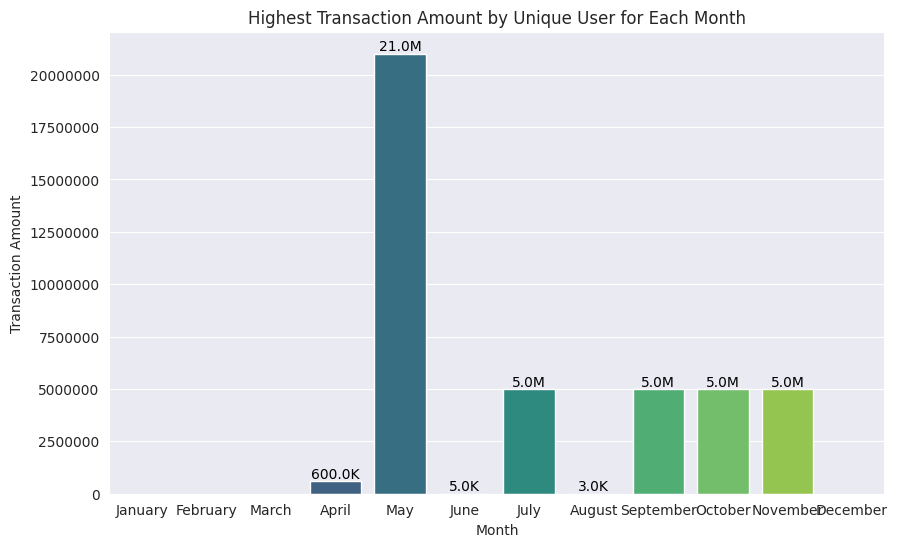

In [13]:
# Group by month and get the index of the highest transaction per month
highest_transaction_per_month_idx = df.groupby([df.index.month])['TransactionAmount'].idxmax()

# Select the rows corresponding to the highest transaction per month
highest_transactions = df.loc[highest_transaction_per_month_idx]

# Map month numbers to names
highest_transactions['Month'] = highest_transactions.index.month.map(month_mapping)

# Remove duplicate months if any (though unlikely in this scenario)
highest_transactions = highest_transactions.drop_duplicates(subset=['Month'])

# Function to format the amounts
def format_amount(value):
    if value >= 1e6:
        return f'{value / 1e6:.1f}M'
    elif value >= 1e3:
        return f'{value / 1e3:.1f}K'
    else:
        return str(value)

# Bar plot for the highest transaction amount by month
plt.figure(figsize=(10, 6))
ax = sns.barplot(x='Month', y='TransactionAmount', data=highest_transactions, palette='viridis', order=month_mapping.values())
ax.ticklabel_format(style='plain', axis='y')  # Disable scientific notation on the y-axis
plt.title('Highest Transaction Amount by Unique User for Each Month')
plt.xlabel('Month')
plt.ylabel('Transaction Amount')

# Adding formatted amounts above the bars
for p in ax.patches:
    formatted_amount = format_amount(p.get_height())
    ax.annotate(formatted_amount, (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=10, color='black', xytext=(0, 5),
                textcoords='offset points')

plt.show()

### (3.) visualization for highest months with more transactions

/tmp/ipykernel_52279/3656609088.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=monthly_total.index, y=monthly_total.values, palette='viridis')


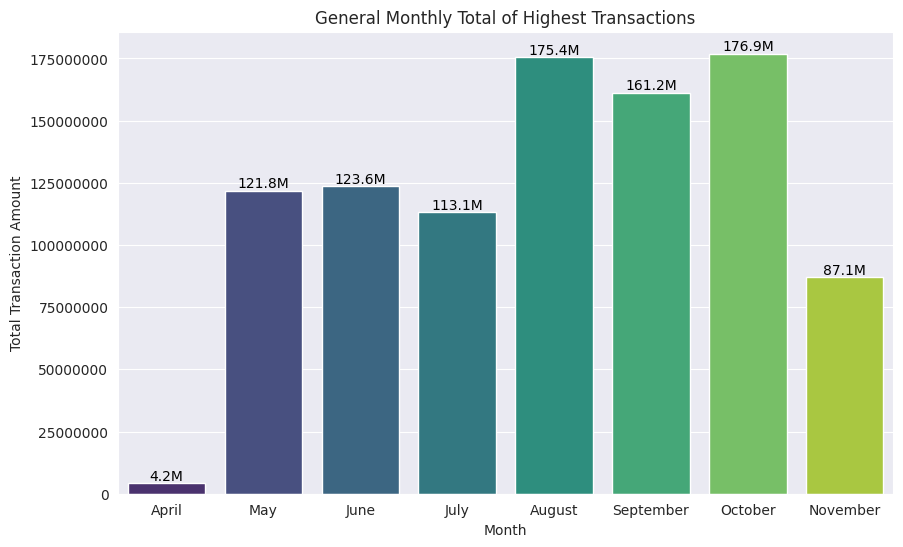

In [14]:
# Group by month and sum the highest transaction amounts per user
monthly_total = df.groupby([df.index.month, 'AccountID'])['TransactionAmount'].max().groupby(level=0).sum()

# Map month numbers to names
monthly_total.index = monthly_total.index.map(month_mapping)

# Function to format the amounts
def format_amount(value):
    if value >= 1e6:
        return f'{value / 1e6:.1f}M'
    elif value >= 1e3:
        return f'{value / 1e3:.1f}K'
    else:
        return str(value)

# Bar plot for total TransactionAmount by month
plt.figure(figsize=(10, 6))
ax = sns.barplot(x=monthly_total.index, y=monthly_total.values, palette='viridis')
ax.ticklabel_format(style='plain', axis='y')  # Disable scientific notation on the y-axis
plt.title('General Monthly Total of Highest Transactions')
plt.xlabel('Month')
plt.ylabel('Total Transaction Amount')

# Adding formatted amounts above the bars
for p in ax.patches:
    formatted_amount = format_amount(p.get_height())
    ax.annotate(formatted_amount, (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=10, color='black', xytext=(0, 5),
                textcoords='offset points')

plt.show()

### (4.) users with an average of 30,000 transactions per month?

In [15]:
monthly_avg = df.groupby([df.index.month, 'AccountID'])['TransactionAmount'].mean()
avg_30000_per_month = monthly_avg[monthly_avg > 30000]

monthly_avg_df = pd.DataFrame(monthly_avg.reset_index())
avg_30000_per_month_df = pd.DataFrame(avg_30000_per_month.reset_index())

In [16]:
avg_30000_per_month_df

,DatePeriod,AccountID,TransactionAmount
0,4,451,150000.0
1,4,3415,200000.0
2,4,6000,200000.0
3,4,20362,40000.0
4,4,23621,116800.0
...,...,...,...
1337,11,402709,39350.0
1338,11,404338,31650.0
1339,11,404356,31750.0
1340,11,405126,500000.0


In [17]:
avg_30000_per_month_df.rename(columns={'DatePeriod': 'Month'}, inplace=True)

In [18]:
avg_30000_per_month_df

,Month,AccountID,TransactionAmount
0,4,451,150000.0
1,4,3415,200000.0
2,4,6000,200000.0
3,4,20362,40000.0
4,4,23621,116800.0
...,...,...,...
1337,11,402709,39350.0
1338,11,404338,31650.0
1339,11,404356,31750.0
1340,11,405126,500000.0


### (5.) lowest AccountID with lesser transactions each month

In [19]:
lowest_transaction_per_month = df.groupby([df.index.month])['TransactionAmount'].idxmin()
lowest_transaction_accounts = df.loc[lowest_transaction_per_month]

In [20]:
lowest_transaction_accounts

,AccountID,TransactionAmount,Status
DatePeriod,,,
2023-04-30 19:58:00,359816,500.0,sent
2023-04-30 19:58:00,350454,1000.0,sent
2023-05-31 22:31:00,368779,500.0,sent
2023-06-30 22:07:00,356050,5000.0,sent
2023-06-30 22:07:00,346453,500.0,sent
2023-07-31 23:26:00,82195,500.0,sent
2023-08-31 22:13:00,355222,500.0,sent
2023-09-30 22:05:00,376835,500.0,sent
2023-10-31 21:06:00,392337,500.0,sent


In [21]:
lowest_transaction_accounts.columns

Index(['AccountID', 'TransactionAmount', 'Status'], dtype='object')

In [22]:
lowest_transaction_accounts.index = lowest_transaction_accounts.index.month.map(month_mapping)

In [23]:
lowest_transaction_accounts

,AccountID,TransactionAmount,Status
DatePeriod,,,
April,359816,500.0,sent
April,350454,1000.0,sent
May,368779,500.0,sent
June,356050,5000.0,sent
June,346453,500.0,sent
July,82195,500.0,sent
August,355222,500.0,sent
September,376835,500.0,sent
October,392337,500.0,sent


/tmp/ipykernel_52279/1893578292.py:3: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.barplot(x=lowest_transaction_accounts.index, y='TransactionAmount', data=lowest_transaction_accounts, ci=None, palette='viridis')
/tmp/ipykernel_52279/1893578292.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=lowest_transaction_accounts.index, y='TransactionAmount', data=lowest_transaction_accounts, ci=None, palette='viridis')


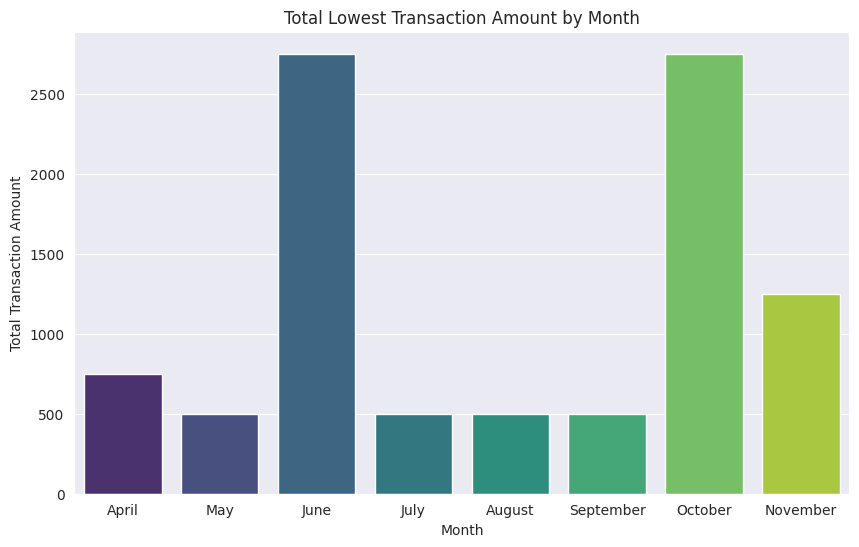

In [24]:
# Bar plot for total TransactionAmount by month
plt.figure(figsize=(10, 6))
ax = sns.barplot(x=lowest_transaction_accounts.index, y='TransactionAmount', data=lowest_transaction_accounts, ci=None, palette='viridis')
ax.ticklabel_format(style='plain', axis='y')  # Disable scientific notation on the y-axis
plt.title('Total Lowest Transaction Amount by Month')
plt.xlabel('Month')
plt.ylabel('Total Transaction Amount')
plt.show()

### (6.) day-of-week AccountID (users) do the highest and lowest transactions so far?

In [25]:
# day_of_week_highest_transactions

In [26]:
# day_of_week_lowest_transactions

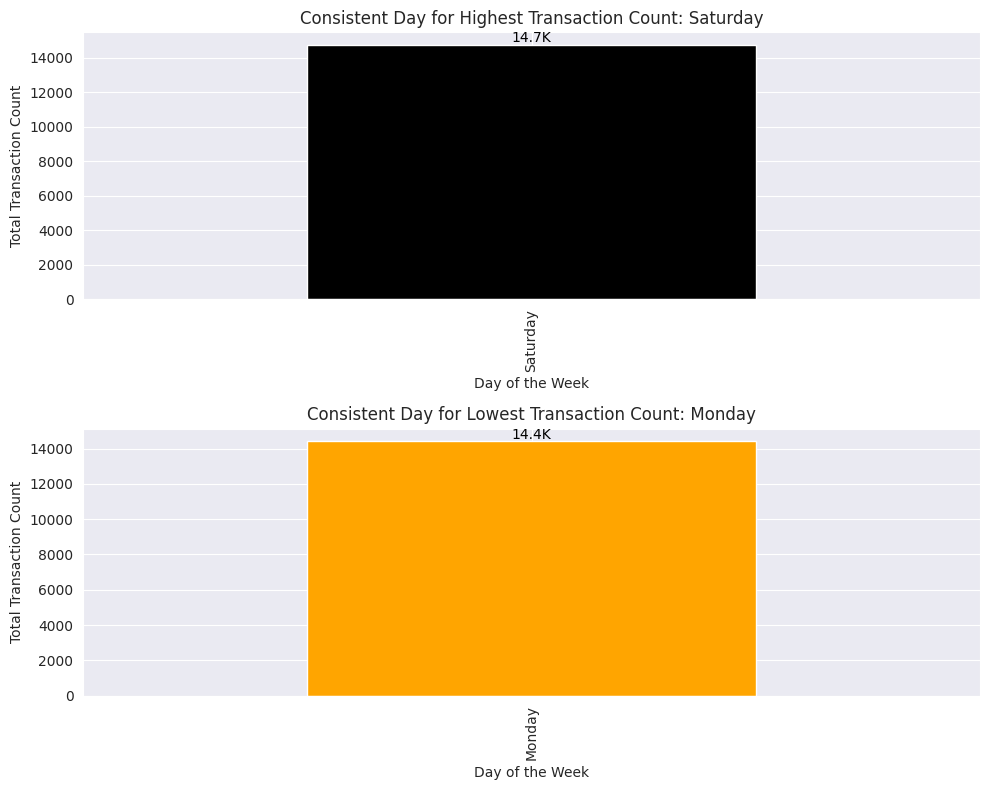

In [48]:
df['DayOfWeek'] = df.index.day_name()
day_of_week_highest_transactions = df.groupby(['AccountID', 'DayOfWeek']).size().idxmax()
day_of_week_lowest_transactions = df.groupby(['AccountID', 'DayOfWeek']).size().idxmin()

consistent_day_highest = day_of_week_highest_transactions[1]
consistent_day_lowest = day_of_week_lowest_transactions[1]

# Function to format the counts
def format_count(value):
    if value >= 1e6:
        return f'{value / 1e6:.1f}M'
    elif value >= 1e3:
        return f'{value / 1e3:.1f}K'
    else:
        return str(value)

# Plot a visualization
fig, axes = plt.subplots(2, 1, figsize=(10, 8))

# Plot for highest transaction counts
transaction_count_highest = df[df['DayOfWeek'] == consistent_day_highest]['DayOfWeek'].value_counts()
transaction_count_highest.plot(kind='bar', ax=axes[0], color='black')
axes[0].set_title(f'Consistent Day for Highest Transaction Count: {consistent_day_highest}')
axes[0].set_xlabel('Day of the Week')
axes[0].set_ylabel('Total Transaction Count')

# Annotate bars for highest transactions
for p in axes[0].patches:
    axes[0].annotate(format_count(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()), 
                     ha='center', va='center', fontsize=10, color='black', xytext=(0, 5), 
                     textcoords='offset points')

# Plot for lowest transaction counts
transaction_count_lowest = df[df['DayOfWeek'] == consistent_day_lowest]['DayOfWeek'].value_counts()
transaction_count_lowest.plot(kind='bar', ax=axes[1], color='orange')
axes[1].set_title(f'Consistent Day for Lowest Transaction Count: {consistent_day_lowest}')
axes[1].set_xlabel('Day of the Week')
axes[1].set_ylabel('Total Transaction Count')

# Annotate bars for lowest transactions
for p in axes[1].patches:
    axes[1].annotate(format_count(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()), 
                     ha='center', va='center', fontsize=10, color='black', xytext=(0, 5), 
                     textcoords='offset points')

plt.tight_layout()
plt.show()

In [41]:
day_of_week_highest_transactions

(524, 'Saturday')

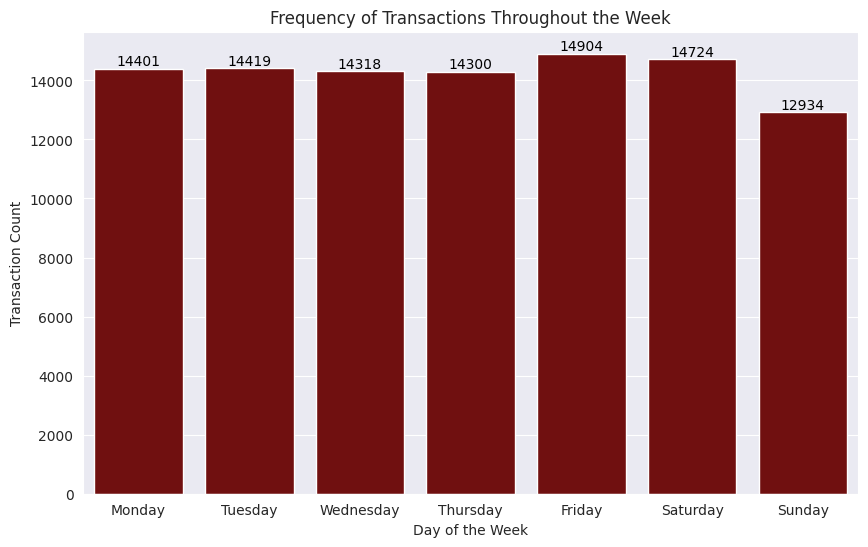

In [67]:
# Plot a visualization for the frequency of transactions throughout the week
plt.figure(figsize=(10, 6))
ax = sns.countplot(x='DayOfWeek', data=df, color='Maroon', order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])

plt.title('Frequency of Transactions Throughout the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Transaction Count')

# Annotate each bar with the transaction count
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', fontsize=10, color='black', xytext=(0, 5), 
                textcoords='offset points')

plt.show()

### (7.) time of day AccountID do the most transactions?

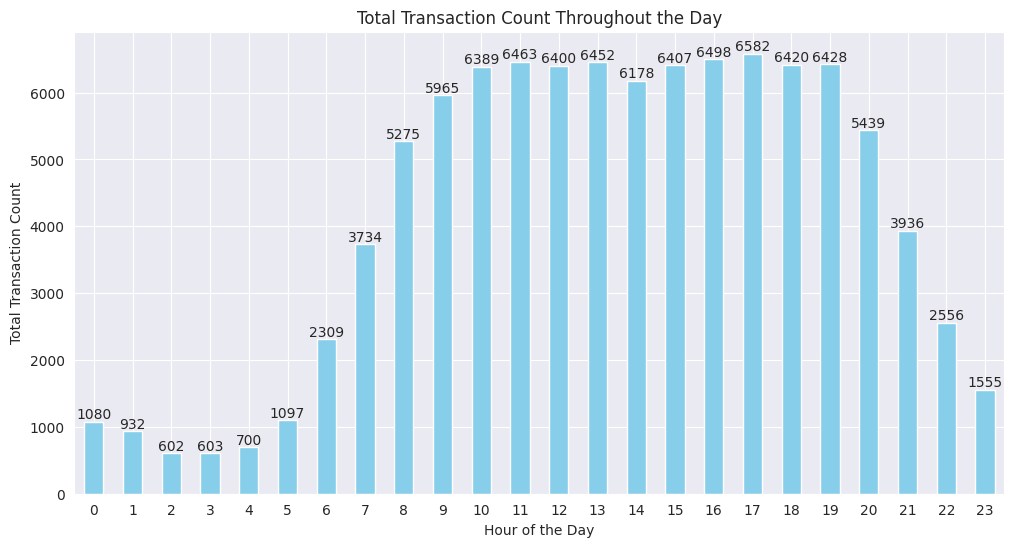

In [72]:
df['HourOfDay'] = df.index.hour

# Visualization plot for total transaction count throughout the day
plt.figure(figsize=(12, 6))

# Group by 'HourOfDay' and count transactions
transaction_count_by_hour = df.groupby('HourOfDay').size()
transaction_count_by_hour.plot(kind='bar', color='skyblue')

plt.title('Total Transaction Count Throughout the Day')
plt.xlabel('Hour of the Day')
plt.ylabel('Total Transaction Count')
plt.xticks(rotation=0)  # For readability

# Annotate each bar with the transaction count
for idx, value in transaction_count_by_hour.items():
    plt.text(idx, value, str(value), ha='center', va='bottom')

plt.show()

# other miscelleneous insights

### 8. transaction volume over time

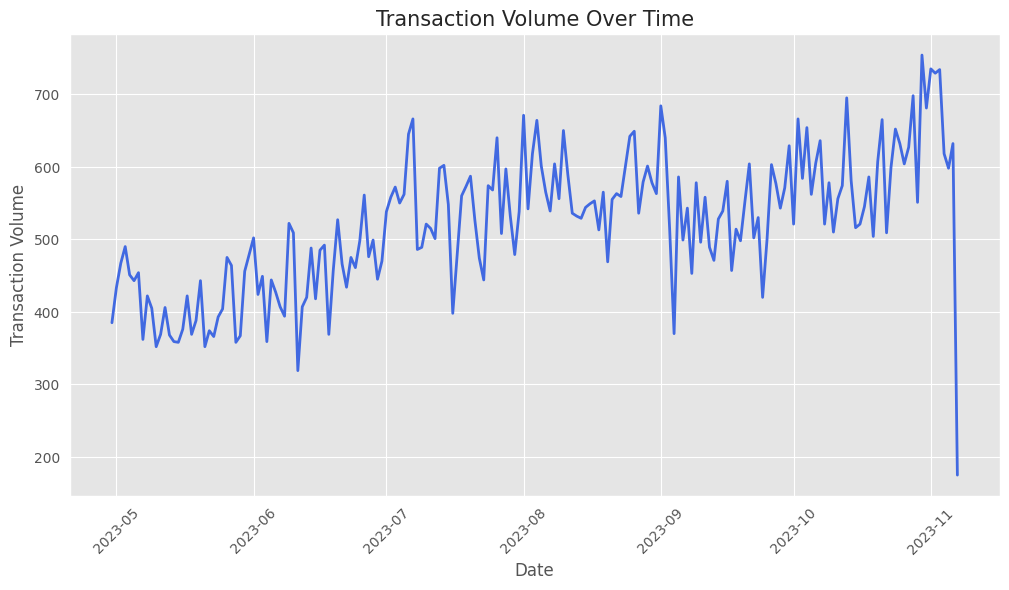

In [82]:
# Resample the data to get transaction volume over time
transaction_volume_over_time = df.resample('D').size()

# Set the plot style for aesthetics
plt.style.use('ggplot')

# Create the figure and the line plot
plt.figure(figsize=(12, 6))
plt.plot(transaction_volume_over_time, color='royalblue', linewidth=2)

# Set title and labels
plt.title('Transaction Volume Over Time', fontsize=15)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Transaction Volume', fontsize=12)

# Beautify the x-axis to display month names
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))  # Format the dates as 'Year-Month'
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())  # Set major ticks to months
plt.xticks(rotation=45)  # Rotate for better readability

# Show the plot with the improved aesthetics and formatting
plt.show()

### 9. transaction status distribution

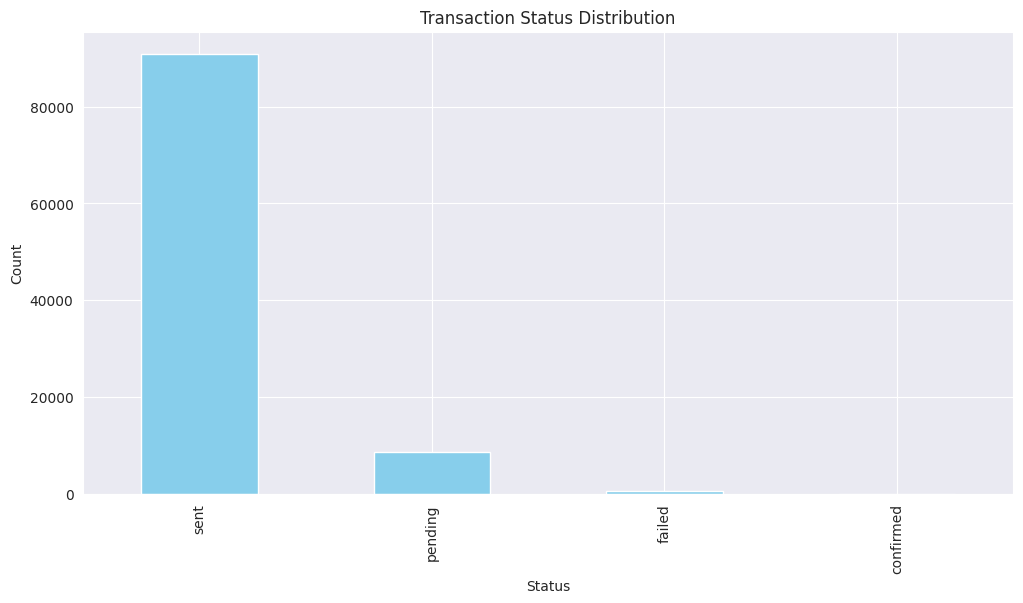

In [33]:
plt.figure(figsize=(12, 6))
status_distribution = df['Status'].value_counts()
status_distribution.plot(kind='bar', color='skyblue')
plt.title('Transaction Status Distribution')
plt.xlabel('Status')
plt.ylabel('Count')
plt.show()


### 10. top 10 users by transaction count

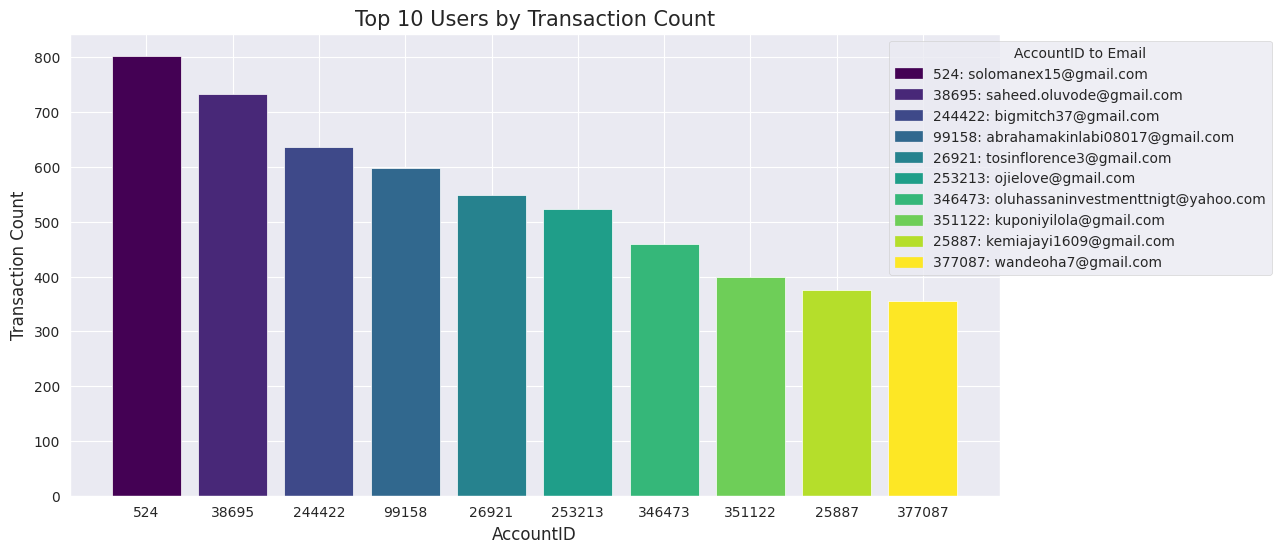

In [92]:
# Mapping AccountID to emails
account_email_map = {
    524: 'solomanex15@gmail.com',
    38695: 'saheed.oluvode@gmail.com',
    244422: 'bigmitch37@gmail.com',
    99158: 'abrahamakinlabi08017@gmail.com',
    26921: 'tosinflorence3@gmail.com',
    253213: 'ojielove@gmail.com',
    346473: 'oluhassaninvestmenttnigt@yahoo.com',
    351122: 'kuponiyilola@gmail.com',
    25887: 'kemiajayi1609@gmail.com',
    377087: 'wandeoha7@gmail.com'
}

# Get top 10 users by transaction count
top_users_by_count = df['AccountID'].value_counts().head(10)

# Create a color palette for the plot
colors = plt.cm.viridis(np.linspace(0, 1, 10))

# Create the figure and the bar plot
plt.figure(figsize=(12, 6))
bars = plt.bar(top_users_by_count.index.map(str), top_users_by_count.values, color=colors)
plt.title('Top 10 Users by Transaction Count', fontsize=15)
plt.xlabel('AccountID', fontsize=12)
plt.ylabel('Transaction Count', fontsize=12)

# Create a custom legend with AccountID to email mapping for the top 10 users
legend_handles = [mpatches.Patch(color=colors[i], label=f'{id}: {account_email_map.get(id, "N/A")}') 
                  for i, id in enumerate(top_users_by_count.index)]
plt.legend(handles=legend_handles, title='AccountID to Email', loc='upper right', bbox_to_anchor=(1.3, 1))

# Show the plot with the enhanced aesthetics
plt.show()

### 11. top 10 users by transaction amount

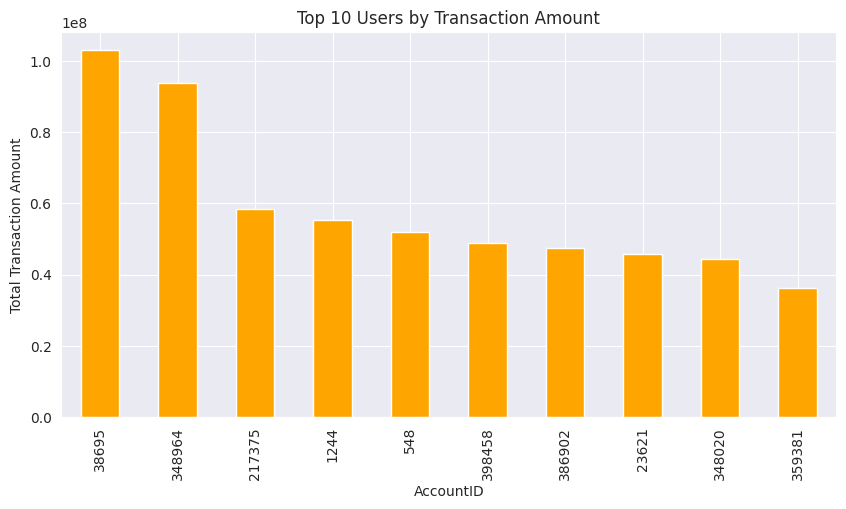

In [35]:
plt.figure(figsize=(10, 5))
top_users_by_amount = df.groupby('AccountID')['TransactionAmount'].sum().nlargest(10)
top_users_by_amount.plot(kind='bar', color='orange')
plt.title('Top 10 Users by Transaction Amount')
plt.xlabel('AccountID')
plt.ylabel('Total Transaction Amount')
plt.show()


### 12. transaction amount over time

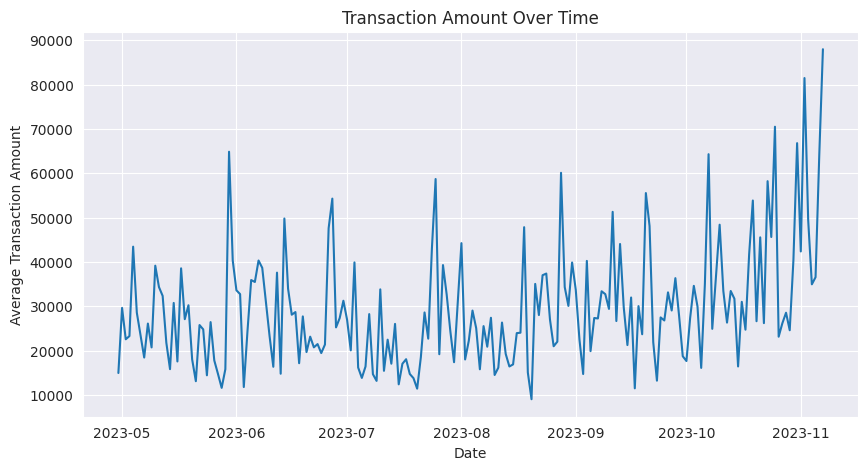

In [36]:
plt.figure(figsize=(10, 5))
transaction_amount_over_time = df.resample('D')['TransactionAmount'].mean()
plt.plot(transaction_amount_over_time)
plt.title('Transaction Amount Over Time')
plt.xlabel('Date')
plt.ylabel('Average Transaction Amount')
plt.show()


### 13. busiest days and hours

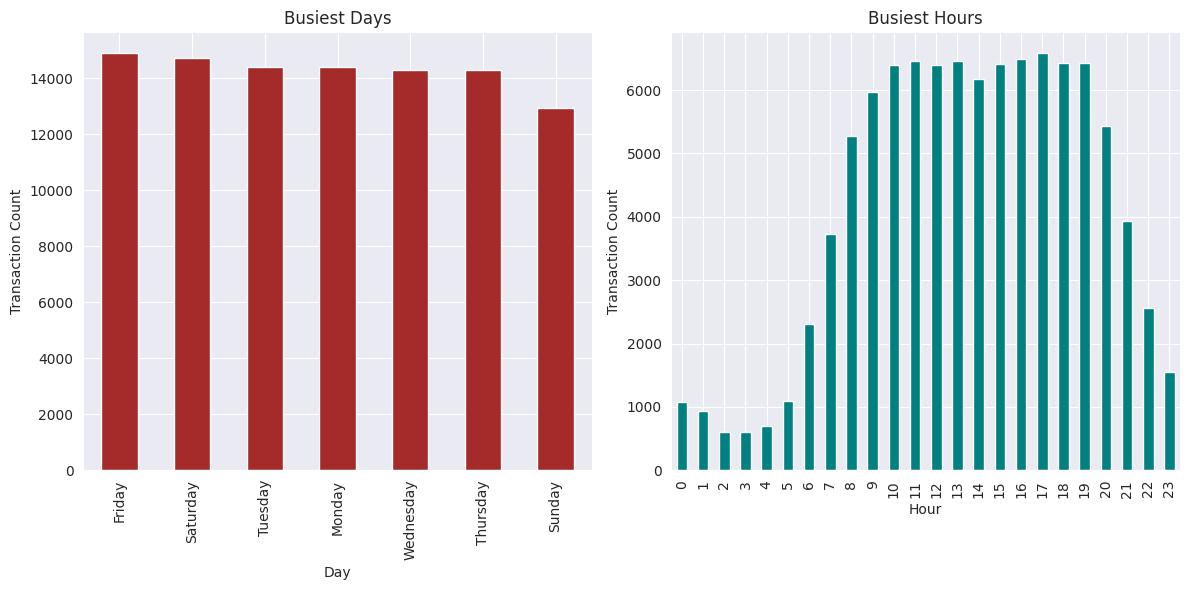

In [37]:
busiest_days = df.index.day_name()
busiest_hours = df.index.hour

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
busiest_days.value_counts().plot(kind='bar', color='brown')
plt.title('Busiest Days')
plt.xlabel('Day')
plt.ylabel('Transaction Count')

plt.subplot(1, 2, 2)
busiest_hours.value_counts().sort_index().plot(kind='bar', color='teal')
plt.title('Busiest Hours')
plt.xlabel('Hour')
plt.ylabel('Transaction Count')

plt.tight_layout()
plt.show()

### 14. transaction status over time

<Figure size 1200x600 with 0 Axes>

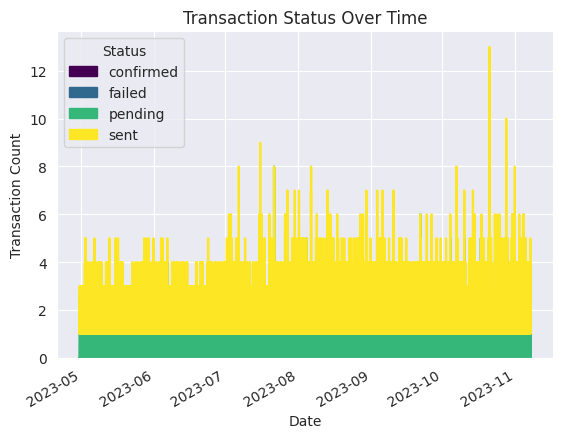

In [38]:
plt.figure(figsize=(12, 6))
status_over_time = df.groupby([df.index, 'Status']).size().unstack()
status_over_time.plot.area(stacked=True, colormap='viridis')
plt.title('Transaction Status Over Time')
plt.xlabel('Date')
plt.ylabel('Transaction Count')
plt.show()

### 15. user engagement over time

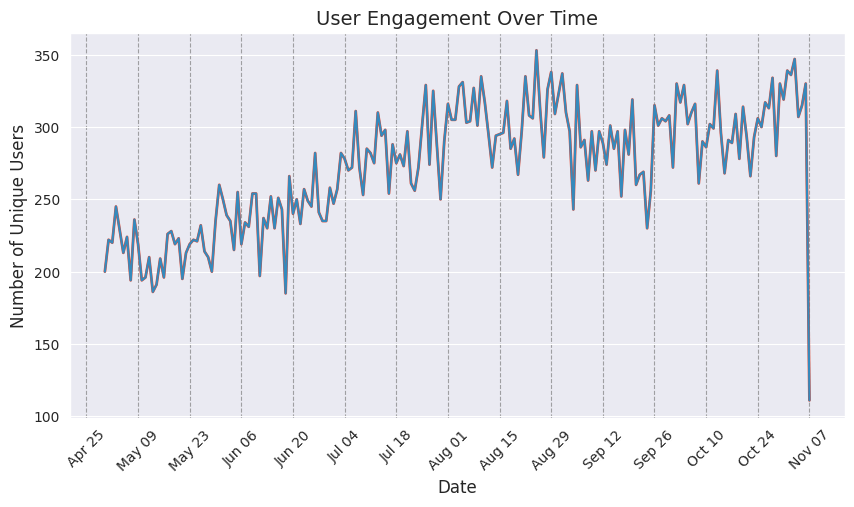

In [99]:
# Calculate user engagement over time
user_engagement_over_time = df.resample('D')['AccountID'].nunique()

# Create the plot
plt.figure(figsize=(10, 5))
plt.plot(user_engagement_over_time, lw=2)  # lw is line width

# Set title and labels
plt.title('User Engagement Over Time', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Number of Unique Users', fontsize=12)

# Format the x-axis to show dates nicely
plt.gca().xaxis.set_major_locator(mdates.WeekdayLocator(interval=2))  # Set major ticks to every second week
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))  # Format the date to show month and day
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability

# Add grid lines bi-weekly
plt.grid(axis='x', linestyle='--', which='major', color='grey', alpha=0.7)

# Remove markers with marker=None
plt.plot(user_engagement_over_time.index, user_engagement_over_time.values, marker=None)

# Show the plot
plt.show()